## Raspagem de dados do site TOTALCORNER e montando o DataFrame

In [22]:
from bs4 import BeautifulSoup
import pandas as pd
import time
import matplotlib.pyplot as plt
import cloudscraper

#Raspagem de dados to site TOTALCORNER
def get_corner_stats(team_id:str,is_home:bool='all'):
    scraper = cloudscraper.create_scraper()    
    html = scraper.get(f'https://www.totalcorner.com/team/view/{team_id}').content

    soup = BeautifulSoup(html, 'html.parser')
    if not soup.find("meta", {"name":"description"}):
        print('CAPTCHA')
        return (None, None)
    team_name = soup.find("meta", {"name":"description"})["content"]
    team_name = team_name.split(",")[0].replace('Team: ','')
    first_half_corners_for = []
    second_half_corners_for = []
    match_corners_for = []
    first_half_corners_against = []
    second_half_corners_against = []
    match_corners_against = []
    total_match_corners = []
    total_first_half_corners = []
    total_second_half_corners =[]
    home_or_away = []
    corners_balance =[]
    against = []



    table_rows = soup.findAll("tr")
    for rows in table_rows:
        #Ignorando jogos que ainda não aconteceram
        if rows.find("span", class_="span_half_corner hide"):
            continue
        match = rows.find("td", class_="match_home")
        #Pegando nome do time que joga em casa
        if match != None:
            home_team = match.find('a').text
        #Ignorando possiveis linhas que não são referente a partidas
        else:
            continue
        match = rows.find("td", class_="match_away")
        #Pegando nome do time que joga fora de casa
        if match != None:
            away_team = match.find('a').text
        #Pegando dados sobre escanteios
        half_corners = rows.find("span", class_="span_half_corner").text
        match_corners = rows.find("span", class_="span_match_corner").text
        home_half_corners = half_corners.replace('(','').replace(')','').split('-')[0]
        away_half_corners = half_corners.replace('(','').replace(')','').split('-')[1]
        home_match_corners = match_corners.split(' ')[0]
        away_match_corners = match_corners.split(' ')[-1]
        home_second_half_corners = int(home_match_corners) - int(home_half_corners)
        away_second_half_corners = int(away_match_corners) - int(away_half_corners)
        #Organizando dados para o dataframe
        if home_team == team_name:
            against.append(away_team)            
            balance = int(home_match_corners) - int(away_match_corners)
            first_half_corners_for.append(int(home_half_corners))
            second_half_corners_for.append(int(home_second_half_corners))
            match_corners_for.append(int(home_match_corners))
            first_half_corners_against.append(int(away_half_corners))
            second_half_corners_against.append(int(away_second_half_corners))
            match_corners_against.append(int(away_match_corners))
            total_match_corners.append(int(home_match_corners) + int(away_match_corners))
            total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
            total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
            home_or_away.append('Home')
            corners_balance.append(balance)

        else:
            against.append(home_team)  
            balance = int(away_match_corners) - int(home_match_corners)
            first_half_corners_for.append(int(away_half_corners))
            second_half_corners_for.append(int(away_second_half_corners))
            match_corners_for.append(int(away_match_corners))
            first_half_corners_against.append(int(home_half_corners))
            second_half_corners_against.append(int(home_second_half_corners))
            match_corners_against.append(int(home_match_corners))
            total_match_corners.append(int(home_match_corners) + int(away_match_corners))
            total_first_half_corners.append(int(home_half_corners) + int(away_half_corners))
            total_second_half_corners.append(int(home_second_half_corners) + int(away_second_half_corners))
            home_or_away.append('Away')
            corners_balance.append(balance)
    #Criando DataFrame
    df = pd.DataFrame(list(zip(
            first_half_corners_for,
            second_half_corners_for,
            match_corners_for,
            first_half_corners_against,
            second_half_corners_against,
            match_corners_against,
            total_match_corners,
            total_first_half_corners,
            total_second_half_corners,
            home_or_away,
            corners_balance,
            against
        )),
        columns=[
            'first_half_corners_for',
            'second_half_corners_for',
            'match_corners_for',
            'first_half_corners_against',
            'second_half_corners_against',
            'match_corners_against',
            'total_match_corners',
            'total_first_half_corners',
            'total_second_half_corners',
            'home_or_away',
            'corners_balance',
            'against'

        ])
    if is_home == 'all':
        return (team_name, df)
    if is_home:
        return (team_name, df[(df.home_or_away == "Home")])
    else:
        return (team_name, df[(df.home_or_away == "Away")])


### Criando relátorio com fairlines de escanteios para as principais partidas de hoje

In [24]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import datetime

games_percentage = 0.70
lower_part = (1-games_percentage)/2
higher_part = games_percentage + lower_part

def get_fairlines(corner_lines_range,home_corner_series,away_corner_series,over_or_under,ft_or_1h):
    fairlines = {}
    if over_or_under.lower() == 'over':
        for corner in corner_lines_range:
                #Percentual de partidas com MAIS de X escanteios
                home = (home_corner_series > corner).mean()
                away = (away_corner_series > corner).mean()
                if home == 0 or away == 0:
                    home = 9999
                else:
                    home = round(1/home,2)
                    away = round(1/away,2)
                fairlines[f'{ft_or_1h}_over_{corner}.5'] = max(home,away)
    else:
        for corner in corner_lines_range:
                #Percentual de partidas com MENOS de X escanteios
                home = (home_corner_series < corner).mean()
                away = (away_corner_series < corner).mean()
                if home == 0 or away == 0:
                    home = 9999
                else:
                    home = round(1/home,2)
                    away = round(1/away,2)
                fairlines[f'{ft_or_1h}_under_{corner - 1 }.5'] = max(home,away)
    return fairlines



def generate_report():
    desired_leagues = ["France Ligue 1",'Portugal Primeira Liga','Netherlands Eredivisie','	Spain Primera Liga','Spain Segunda','Italy Serie B',
                       'England Championship','England Premier League','Germany Bundesliga I','Italy Serie A','Colombia Primera A','Uruguay Apertura',
                        'Chile Primera Division','Argentina Liga Profesional','USA MLS','Paraguay Division Profesional',
                       'Venezuela Primera Division','Mexico Liga MX','Japan J-League','Germany Bundesliga II','UEFA Champions League',
                       'Copa do Brasil']
    result = []
    html = requests.get('https://www.totalcorner.com/match/today').content
    soup = BeautifulSoup(html, 'html.parser')
    table_rows = soup.findAll("tr")
    #Lendo as linhas da tabela
    for rows in table_rows:
        game = {}
        minutes = rows.find('span', class_="match_status_minutes")
        #ignorando linhas que não tem a coluna de tempo da partida
        if not minutes:
            continue
        #ignorando partidas que já começaram
        if minutes.text == "":
            links = rows.findAll('a', href=True)
            league = links[0].text
            #Filtrando ligas
            if league not in desired_leagues:
                continue
            #Pegando ID dos times
            home_team_id = links[1]['href'].split('/')[-1]
            away_team_id = links[2]['href'].split('/')[-1]
            #Pegando os dados de escanteios dos times.
            home_team_name, df_home = get_corner_stats(home_team_id)
            away_team_name, df_away = get_corner_stats(away_team_id)
            #Encerra o loop caso o site peça CAPTCHA
            if not (home_team_name and away_team_name):
                break
            else:
                game['Name'] = f'{home_team_name} X {away_team_name}'
                #Percentual de partidas com saldo de escanteios positivos e negativos
                home_balance = round((df_home.corners_balance > 0).mean()*100)
                negative_home_balance = round((df_home.corners_balance < 0).mean()*100)
                away_balance = round((df_away.corners_balance > 0).mean()*100)
                negative_away_balance = round((df_away.corners_balance < 0).mean()*100)
                #Definindo linhas de over e under escanteios para analise
                first_half_over_range = range(1,6)
                first_half_under_range = range(7,4,-1)
                full_time_over_range = range(6,13)
                full_time_under_range = range(12,8,-1)

                print(f'{home_team_name} X {away_team_name}')
                game.update(get_fairlines(first_half_over_range,df_home.total_first_half_corners,df_away.total_first_half_corners,'over','1H'))
                game.update(get_fairlines(first_half_under_range,df_home.total_first_half_corners,df_away.total_first_half_corners,'under','1H'))
                game.update(get_fairlines(full_time_over_range,df_home.total_match_corners,df_away.total_match_corners,'over','FT'))
                game.update(get_fairlines(full_time_under_range,df_home.total_match_corners,df_away.total_match_corners,'under','FT'))
                result.append(game)

                balance_dif = home_balance - away_balance 
                if abs(balance_dif) >= 40:
                    if(home_balance > away_balance):
                        fair = 1/((home_balance + negative_away_balance)/200)
                        game.update({'most_corners':home_team_name,'most_corners_fairline':fair})
                    else:
                        fair = 1/((negative_home_balance + away_balance)/200)
                        game.update({'most_corners':home_team_name,'most_corners_fairline':fair})
                else:
                    game.update({'most_corners':'-','most_corners_fairline':'-'})
    result_df = pd.DataFrame.from_records(result)
    result_df.to_excel(f'fairlines{datetime.date.today()}.xlsx', index=False)      



generate_report()

Boyaca Chico X America de Cali


### Relátorio teste confronto entre duas equipes

Deportes Tolima Jogando em casa


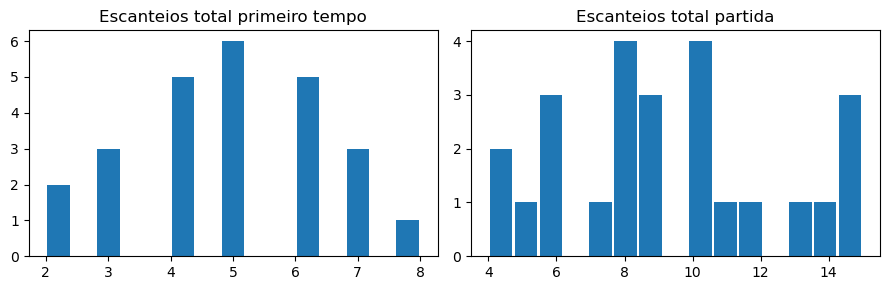

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 7.5 escanteios
1H 85% das partidas + de  2.5 escanteios
1H partidas com menos de 6.5  84 % Fairline: 1.19
1H partidas com menos de 5.5  64 % Fairline: 1.56
1H partidas com menos de 4.5  40 % Fairline: 2.5
1H partidas com mais de 1.5  100 % Fairline: 1.0
1H partidas com mais de 2.5  92 % Fairline: 1.09
1H partidas com mais de 3.5  80 % Fairline: 1.25
JOGO COMPLETO: 
FT 85% das partidas - de  14.5 escanteios
FT 85% das partidas + de  5.5 escanteios
FT partidas com menos de 10.5  72 % Fairline: 1.39
FT partidas com menos de 9.5  56 % Fairline: 1.79
FT partidas com menos de 8.5  44 % Fairline: 2.27
FT partidas com mais de 6.5  76 % Fairline: 1.32
FT partidas com mais de 7.5  72 % Fairline: 1.39
FT partidas com mais de 8.5  56 % Fairline: 1.79
Partidas com saldo de escanteios positivo:  40 %
Partidas com saldo de escanteios negativo:  60 %
Partidas escanteios empatados:  0 %
Média escanteios por partida:  9
desvio padrão:  3


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
0,2,2,4,4,2,6,10,6,4,Home,-2,Junior
1,4,4,8,1,2,3,11,5,6,Away,5,Envigado FC
2,2,2,4,2,3,5,9,4,5,Home,-1,Deportivo Pasto
3,3,1,4,2,4,6,10,5,5,Away,-2,Academia Puerto Cabello
4,0,2,2,4,3,7,9,4,5,Away,-5,Independiente Medellin
5,4,0,4,0,1,1,5,4,1,Home,3,Millonarios
6,3,2,5,1,2,3,8,4,4,Home,2,Atletico Huila
7,1,3,4,4,2,6,10,5,5,Away,-2,Atletico Bucaramanga
8,5,1,6,1,1,2,8,6,2,Away,4,Deportivo Pereira
9,4,4,8,1,6,7,15,5,10,Home,1,Deportivo Cali


Deportivo Pasto Jogando fora de casa


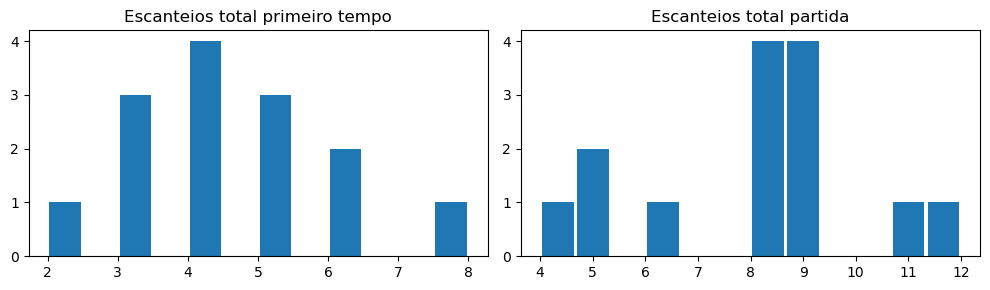

 PRIMEIRO TEMPO: 
1H 85% das partidas - de 6.5 escanteios
1H 85% das partidas + de  2.5 escanteios
1H partidas com menos de 6.5  93 % Fairline: 1.08
1H partidas com menos de 5.5  79 % Fairline: 1.27
1H partidas com menos de 4.5  57 % Fairline: 1.75
1H partidas com mais de 1.5  100 % Fairline: 1.0
1H partidas com mais de 2.5  93 % Fairline: 1.08
1H partidas com mais de 3.5  71 % Fairline: 1.4
JOGO COMPLETO: 
FT 85% das partidas - de  11.5 escanteios
FT 85% das partidas + de  4.5 escanteios
FT partidas com menos de 10.5  86 % Fairline: 1.17
FT partidas com menos de 9.5  86 % Fairline: 1.17
FT partidas com menos de 8.5  57 % Fairline: 1.75
FT partidas com mais de 6.5  71 % Fairline: 1.4
FT partidas com mais de 7.5  71 % Fairline: 1.4
FT partidas com mais de 8.5  43 % Fairline: 2.33
Partidas com saldo de escanteios positivo:  14 %
Partidas com saldo de escanteios negativo:  71 %
Partidas escanteios empatados:  14 %
Média escanteios por partida:  8
desvio padrão:  2


,first_half_corners_for,second_half_corners_for,match_corners_for,first_half_corners_against,second_half_corners_against,match_corners_against,total_match_corners,total_first_half_corners,total_second_half_corners,home_or_away,corners_balance,against
0,3,1,4,2,2,4,8,5,3,Away,0,Atletico Huila
2,2,3,5,2,2,4,9,4,5,Away,1,Deportes Tolima
4,2,3,5,3,4,7,12,5,7,Away,-2,Jaguares de Cordoba
5,0,1,1,3,1,4,5,3,2,Away,-3,Millonarios
7,3,0,3,5,1,6,9,8,1,Away,-3,Once Caldas
9,1,1,2,1,1,2,4,2,2,Away,0,Boyaca Chico
11,0,0,0,4,4,8,8,4,4,Away,-8,Independiente Santa Fe
13,0,2,2,6,3,9,11,6,5,Away,-7,FBC Melgar
15,3,2,5,2,2,4,9,5,4,Away,1,Rionegro Aguilas
17,0,1,1,4,0,4,5,4,1,Away,-3,America de Cali


In [25]:
team_id = 931
team2_id = 1005 

home_name, df_home = get_corner_stats(team_id)
away_name, df_away = get_corner_stats(team2_id,False)

print(home_name, "Jogando em casa")
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.hist(df_home.total_first_half_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_home.total_match_corners.tolist(), int(df_home.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()

print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_home.total_first_half_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('1H 85% das partidas + de ', df_home.total_first_half_corners.quantile(0.15, interpolation="lower")-0.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_home.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_home.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_home.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_home.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_home.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_home.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_home.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_home.total_match_corners.quantile(0.85,interpolation="higher")+0.5, "escanteios")
print('FT 85% das partidas + de ', df_home.total_match_corners.quantile(0.15,interpolation="lower")-0.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_home.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_home.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_home.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_home.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_home.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_home.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_home.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_home.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_home.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_home.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_home.total_match_corners).mean()))
print('desvio padrão: ', round((df_home.total_match_corners).std()))
display(df_home)


print(away_name,"Jogando fora de casa")
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.hist(df_away.total_first_half_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total primeiro tempo")
plt.plot()
plt.subplot(1, 2, 2)
plt.hist(df_away.total_match_corners.tolist(), int(df_away.total_match_corners.quantile(1)), rwidth=0.9)
plt.title("Escanteios total partida")
plt.plot()
plt.tight_layout()
plt.show()
print(" PRIMEIRO TEMPO: ")
print('1H 85% das partidas - de', df_away.total_first_half_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('1H 85% das partidas + de ', df_away.total_first_half_corners.quantile(0.15, interpolation="lower")-.5, "escanteios")
print('1H partidas com menos de 6.5 ', round((df_away.total_first_half_corners < 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 7).mean(),2))
print('1H partidas com menos de 5.5 ', round((df_away.total_first_half_corners < 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 6).mean(),2))
print('1H partidas com menos de 4.5 ', round((df_away.total_first_half_corners < 5).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners < 5).mean(),2))
print('1H partidas com mais de 1.5 ', round((df_away.total_first_half_corners > 1).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 1).mean(),2))
print('1H partidas com mais de 2.5 ', round((df_away.total_first_half_corners > 2).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 2).mean(),2))
print('1H partidas com mais de 3.5 ', round((df_away.total_first_half_corners > 3).mean()*100), "%", 'Fairline:',round(1/(df_away.total_first_half_corners > 3).mean(),2))
print("JOGO COMPLETO: ")
print('FT 85% das partidas - de ', df_away.total_match_corners.quantile(0.85,interpolation="higher")+.5, "escanteios")
print('FT 85% das partidas + de ', df_away.total_match_corners.quantile(0.15,interpolation="lower")-.5, "escanteios")
print('FT partidas com menos de 10.5 ', round((df_away.total_match_corners < 11).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 11).mean(),2))
print('FT partidas com menos de 9.5 ', round((df_away.total_match_corners < 10).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 10).mean(),2))
print('FT partidas com menos de 8.5 ', round((df_away.total_match_corners < 9).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners < 9).mean(),2))
print('FT partidas com mais de 6.5 ', round((df_away.total_match_corners > 6).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 6).mean(),2))
print('FT partidas com mais de 7.5 ', round((df_away.total_match_corners > 7).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 7).mean(),2))
print('FT partidas com mais de 8.5 ', round((df_away.total_match_corners > 8).mean()*100), "%", 'Fairline:',round(1/(df_away.total_match_corners > 8).mean(),2))
print('Partidas com saldo de escanteios positivo: ', round((df_away.corners_balance > 0).mean()*100), "%")
print('Partidas com saldo de escanteios negativo: ', round((df_away.corners_balance < 0).mean()*100), "%")
print('Partidas escanteios empatados: ', round((df_away.corners_balance == 0).mean()*100), "%")
print('Média escanteios por partida: ', round((df_away.total_match_corners).mean()))
print('desvio padrão: ', round((df_away.total_match_corners).std()))
display(df_away)
